In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):


    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Part A

# 1. Load packages & import Datas

In [46]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

from glob import glob
from skimage.io import imread
from os import listdir
from skimage import io
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import time
import copy
from tqdm import tqdm_notebook as tqdm
from sklearn import svm
import gc
from sklearn.decomposition import IncrementalPCA

In [47]:
folder = '../input/breast-histopathology-images/IDC_regular_ps50_idx5/'
patient_ids = os.listdir(folder)
p_id = listdir(folder)

class_0_total = 0
class_1_total = 0

for patient_id in patient_ids:
    class_0_files = os.listdir(folder + patient_id + '/0')
    class_1_files = os.listdir(folder + patient_id + '/1')

    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 

# 2. Datas Description

In [48]:
columns = ["patient_id","diagnosis","path"]
data_rows = []

for patient_id in patient_ids:
    for outcome in [0,1]:
        class_path = folder + patient_id + '/' + str(outcome) + '/'
        imgs = os.listdir(class_path)
        
        # Extracting Image Paths
        img_paths = [class_path + img + '/' for img in imgs]
        
        for path in img_paths:
            values = [patient_id,outcome,path]
            data_rows.append({k:v for (k,v) in zip(columns,values)})

In [49]:
data = pd.DataFrame(data_rows)
#data = data.sample(frac = 0.5)
print(data.shape)
display(data)

(277524, 3)


,patient_id,diagnosis,path
0,10295,0,../input/breast-histopathology-images/IDC_regu...
1,10295,0,../input/breast-histopathology-images/IDC_regu...
2,10295,0,../input/breast-histopathology-images/IDC_regu...
3,10295,0,../input/breast-histopathology-images/IDC_regu...
4,10295,0,../input/breast-histopathology-images/IDC_regu...
...,...,...,...
277519,12873,1,../input/breast-histopathology-images/IDC_regu...
277520,12873,1,../input/breast-histopathology-images/IDC_regu...
277521,12873,1,../input/breast-histopathology-images/IDC_regu...
277522,12873,1,../input/breast-histopathology-images/IDC_regu...


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   diagnosis   277524 non-null  int64 
 2   path        277524 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.4+ MB


In [51]:
data.describe()

,diagnosis
count,277524.000000
mean,0.283889
std,0.450884
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [52]:
data['diagnosis'].value_counts()

0    198738
1     78786
Name: diagnosis, dtype: int64

0    198738
1     78786
Name: diagnosis, dtype: int64


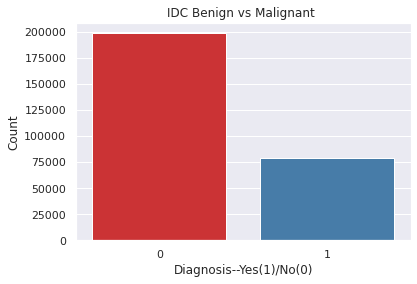

The difference between benign and malignant : 119952


In [53]:
data_copy_1=data.iloc[:277524,:]
from PIL.Image import open
data_count=data_copy_1['diagnosis'].value_counts()
print(data_count)
sns.countplot(data_copy_1['diagnosis'],palette="Set1")
plt.title('IDC Benign vs Malignant ')
plt.xlabel("Diagnosis--Yes(1)/No(0)")
plt.ylabel("Count")
plt.show()
print('The difference between benign and malignant :'+" "
      +str(data_count[0]-data_count[1]))

## Healthy Tissue Samples Vs Cancerous Tissue Samples


In [54]:
positive_sample = np.random.choice(data[data.diagnosis==1].index.values, size=100, replace=False)
negative_sample = np.random.choice(data[data.diagnosis==0].index.values, size=100, replace=False)

rows = 5
cols = 5

Cancer Tissue

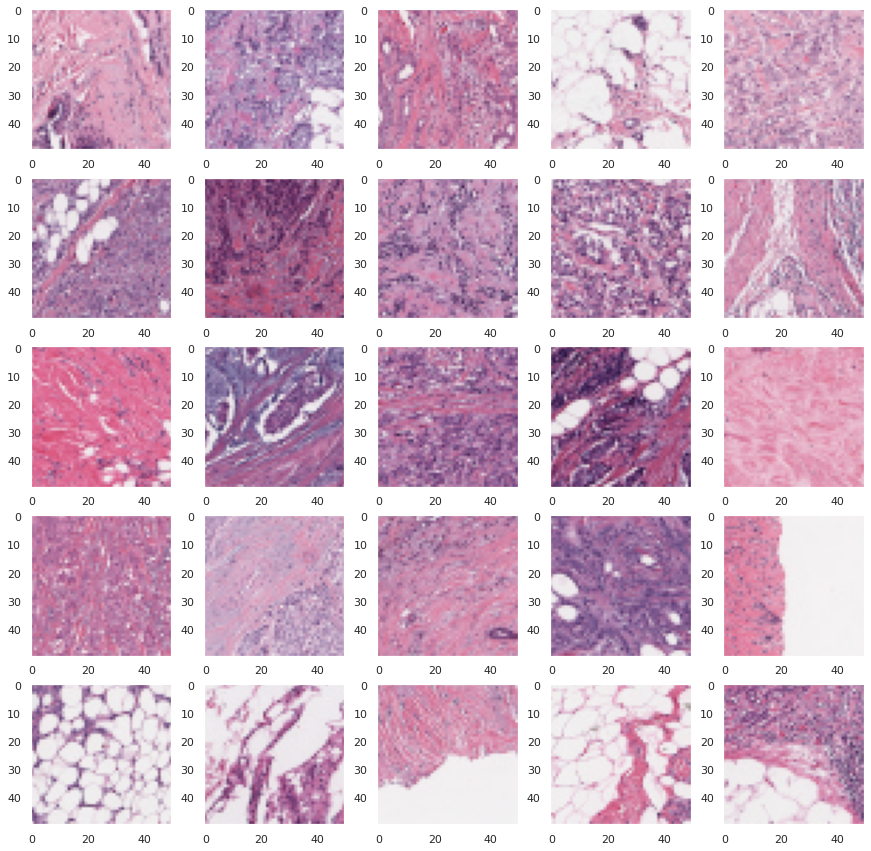

In [55]:
fig,ax = plt.subplots(rows,cols,figsize = (15,15))

for row in range(rows):
    for col in range(cols):
        
        idx = positive_sample[col + cols*row]
        image = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(image[:,:,:])
        ax[row,col].grid(False)

Healthy Tissue

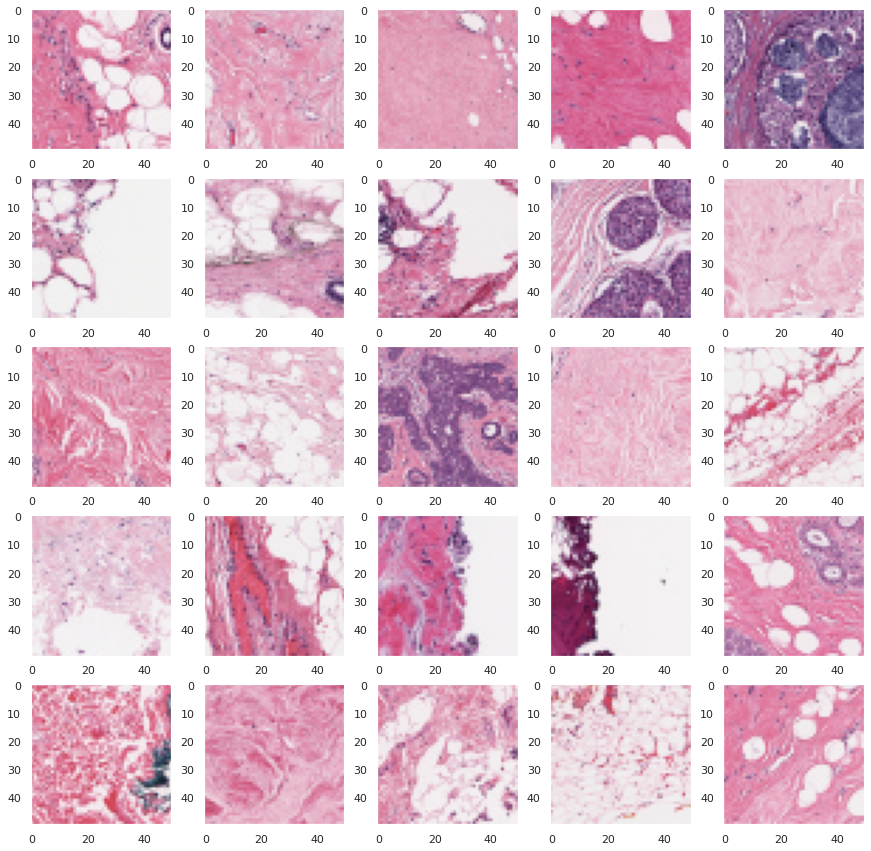

In [56]:
fig,ax = plt.subplots(rows,cols,figsize = (15,15))

for row in range(rows):
    for col in range(cols):
        
        idx = negative_sample[col + cols*row]
        image = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(image[:,:,:])
        ax[row,col].grid(False)

# 3. Pre-processing Images

In [57]:
#I wanted to split datas into train set and test set, 
#but I came up with a better way to split data--use KFold, 
#so the splitting codes are without effect now.

#split datas
from sklearn.model_selection import train_test_split
data = data.sample(frac = 0.48)
train_data_append,test_data_append=train_test_split(data, test_size = 0.3)
print(train_data_append.shape)
print(test_data_append.shape)

(93248, 3)
(39964, 3)


In [58]:
import gc
from sklearn.decomposition import IncrementalPCA
#apply pca
def rgb_to_grayscale(img_paths, batch_size = 15000):
    num_of_imgs = img_paths.shape[0]
    pos = 0
    grid = np.zeros((num_of_imgs*2500, 3))

    for img_path in tqdm(img_paths, total=num_of_imgs):
        img = io.imread(img_path)
        img = img.reshape(-1, 3)
        grid[pos: pos + img.shape[0],:] = img
        pos += img.shape[0]
        
    ipca = IncrementalPCA(n_components=1, batch_size=batch_size)
    ipca.fit(grid)
    del grid
    gc.collect()
    
    return ipca

In [59]:
#all
all_image_paths=data['path']
all_rgb_pca=rgb_to_grayscale(all_image_paths)

  0%|          | 0/133212 [00:00<?, ?it/s]

In [60]:
all_rgb_pca.explained_variance_ratio_.sum()

0.9300454837647093

In [61]:
#train
#train_image_paths=train_data_append['path']
#train_rgb_pca=rgb_to_grayscale(train_image_paths)

In [62]:
idc = 0
nidc = 0
for patient_id in p_id:
    sub_nidc = listdir(folder + patient_id + '/0')
    sub_idc = listdir(folder + patient_id + '/1')

    nidc += len(sub_nidc)
    idc += len( sub_idc) 


In [63]:
#test
#test_image_paths=test_data_append['path']
#test_rgb_pca=rgb_to_grayscale(test_image_paths)


In [64]:
#test_rgb_pca.explained_variance_ratio_.sum()

In [65]:
def apply_rgb_to_pca(img,pca_object):
    
    img = img.reshape(-1, 3)
    
    img = pca_object.transform(img)
    
    img = img.flatten()
    return img

In [66]:
#Transorming RGB image paths to single scale image array using PCA
#all
all_image_paths = data['path']
all_image_targets = data['diagnosis']

In [67]:
all_img_array = np.zeros((all_image_paths.shape[0],2500))

for i,all_image_paths in tqdm(enumerate(all_image_paths),total = all_image_paths.shape[0]):
    img = io.imread(all_image_paths)
    try:
        all_img_array[i:img.shape[0]] = apply_rgb_to_pca(img,all_rgb_pca)
        
    except:
        pass

  0%|          | 0/133212 [00:00<?, ?it/s]

In [68]:
#train
#train_image_paths = train_data_append['path']
#train_image_targets = train_data_append['diagnosis']

In [69]:
#train_img_array = np.zeros((train_image_paths.shape[0],2500))

#for i,train_image_paths in tqdm(enumerate(train_image_paths),total = train_image_paths.shape[0]):
    #img = io.imread(train_image_paths)
    #try:
           #train_img_array[i:img.shape[0]] = apply_rgb_to_pca(img,rgb_pca)
    #except:
        #pass

In [70]:
#test
#test_image_paths = test_data_append['path']
#test_image_targets = test_data_append['diagnosis']

In [71]:
#test_img_array = np.zeros((test_image_paths.shape[0],2500))

#for i,test_image_paths in tqdm(enumerate(test_image_paths),total = test_image_paths.shape[0]):
    #img = io.imread(test_image_paths)
    #try:
        #    test_img_array[i:img.shape[0]] = apply_rgb_to_pca(img,rgb_pca)
    #except:
          # pass

In [72]:
#fit the pixel PCA Object
def fit_pixel_pca(img_array,n_components=50,batch_size=20000):
    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    ipca.fit(img_array)
    del img_array
    gc.collect()
    return ipca

In [73]:
#all
all_pca=fit_pixel_pca(all_img_array)
print(all_pca)

IncrementalPCA(batch_size=20000, n_components=50)


In [74]:
#train
#train_pca = fit_pixel_pca(train_img_array)
#print(train_pca)

In [75]:
#test
#test_pca=fit_pixel_pca(test_img_array)

In [76]:
#all
all_data_train_X=all_img_array#all_pca.transform(all_img_array)
print(all_img_array.shape)

(133212, 2500)


In [77]:
#train
#train_X = train_pca.transform(train_img_array)

In [78]:
#test
#test_X=test_pca.transform(test_img_array)

# 4. Algorithms & Methodology

# 4.1 Cross validation (more accurate in calculating accuracy)--K-Fold

In [79]:
from sklearn.model_selection import KFold


In [80]:

from sklearn.metrics import confusion_matrix



def classification_model(model,prediction_input,output):
    kf = KFold(n_splits=5,shuffle=True, random_state=1)
    error = []
    
    for train, test in kf.split(data):
        train_X = (all_data_train_X[train,:])
        train_y = data['diagnosis'].iloc[train]
        x = train_X[~np.all(train_X == 0, axis=1)]
        y = train_y[~np.all(train_X == 0, axis=1)]
        model.fit(x, y)
        test_X=all_data_train_X[test,:]
        test_y=data['diagnosis'].iloc[test]
        x = test_X[~np.all(test_X == 0, axis=1)]
        y = test_y[~np.all(test_X == 0, axis=1)]
        error.append(model.score(x,y))
        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    fig, ax = plt.subplots(figsize=(5,5))
    conf_matrix = confusion_matrix(model.predict(x),y)
    conf_matrix = conf_matrix/np.sum(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, cmap=plt.cm.jet,ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show(block=False)
    print("The Accuracy Is : %s" % "{0:.3%}".format(np.mean(error)))
    print(error)
    return error


# 4.2 Training and prediction

# 4.2.1 Decision Tree

Cross-Validation Score : 60.000%
Cross-Validation Score : 63.333%
Cross-Validation Score : 64.444%
Cross-Validation Score : 65.000%
Cross-Validation Score : 63.429%


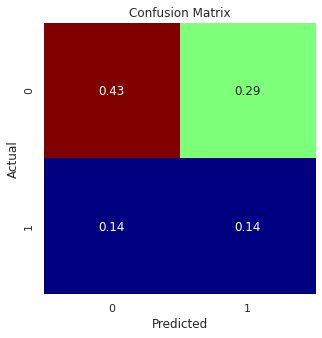

The Accuracy Is : 63.429%
[0.6, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.5714285714285714]


In [81]:
acc_results=[[],[]]
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
#classification_model(dt_model,all_data_train_X,data['diagnosis'])
acc_results[0] += ["Decision Tree"]
acc_results[1] += [classification_model(dt_model,all_data_train_X,data['diagnosis'])]

# 4.2.2 Random Forest Classifier

Cross-Validation Score : 70.000%
Cross-Validation Score : 80.833%
Cross-Validation Score : 76.111%
Cross-Validation Score : 80.000%
Cross-Validation Score : 81.143%


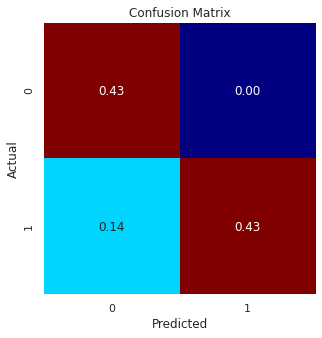

The Accuracy Is : 81.143%
[0.7, 0.9166666666666666, 0.6666666666666666, 0.9166666666666666, 0.8571428571428571]


In [82]:
from sklearn.ensemble import RandomForestClassifier

rfc_model=RandomForestClassifier(n_estimators=100)
#classification_model(rfc_model,all_data_train_X,data['diagnosis'])
acc_results[0] += ["Random Forest"]
acc_results[1] += [classification_model(rfc_model,all_data_train_X,data['diagnosis'])]

# 4.2.3 SVM

In [83]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf',gamma = 'auto' )
svc_n = SVC(gamma = 'auto')

Cross-Validation Score : 70.000%
Cross-Validation Score : 76.667%
Cross-Validation Score : 73.333%
Cross-Validation Score : 75.833%
Cross-Validation Score : 69.238%


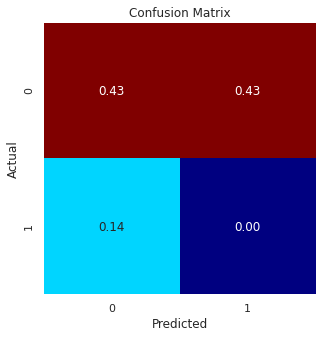

The Accuracy Is : 69.238%
[0.7, 0.8333333333333334, 0.6666666666666666, 0.8333333333333334, 0.42857142857142855]


In [84]:
svm_model = svm.SVC()
#classification_model(svm_model,all_data_train_X,data['diagnosis'])
acc_results[0] += ["SVM"]
acc_results[1] += [classification_model(svm_model,all_data_train_X,data['diagnosis'])]

# 4.2.4 Logistic Regression 

Cross-Validation Score : 60.000%
Cross-Validation Score : 75.833%
Cross-Validation Score : 61.667%
Cross-Validation Score : 65.000%
Cross-Validation Score : 63.429%


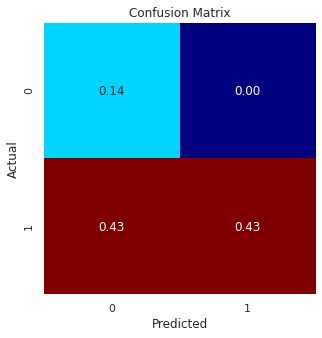

The Accuracy Is : 63.429%
[0.6, 0.9166666666666666, 0.3333333333333333, 0.75, 0.5714285714285714]


In [85]:
from sklearn.linear_model import LogisticRegression 
lr_model=LogisticRegression()
#classification_model(lr_model,all_data_train_X,data['diagnosis'])
acc_results[0] += ['Logistic Regression']
acc_results[1] += [classification_model(lr_model,all_data_train_X,data['diagnosis'])]

# 4.2.5 K Neighbors

Cross-Validation Score : 80.000%
Cross-Validation Score : 85.833%
Cross-Validation Score : 75.741%
Cross-Validation Score : 79.722%
Cross-Validation Score : 80.921%


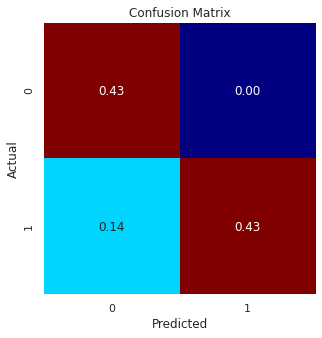

The Accuracy Is : 80.921%
[0.8, 0.9166666666666666, 0.5555555555555556, 0.9166666666666666, 0.8571428571428571]


In [86]:
from sklearn.neighbors import KNeighborsClassifier
kn_model = KNeighborsClassifier()
#classification_model(kn_model,all_data_train_X,data['diagnosis'])
acc_results[0] += ["K Neighbors"]
acc_results[1] += [classification_model(kn_model,all_data_train_X,data['diagnosis'])]

# 4.2.6 Naive Bayesian

Cross-Validation Score : 80.000%
Cross-Validation Score : 85.833%
Cross-Validation Score : 75.741%
Cross-Validation Score : 75.556%
Cross-Validation Score : 71.873%


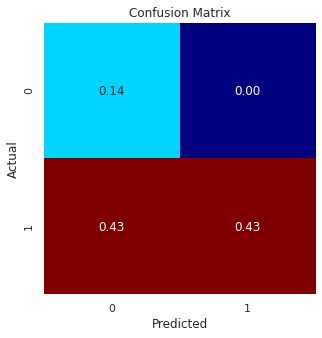

The Accuracy Is : 71.873%
[0.8, 0.9166666666666666, 0.5555555555555556, 0.75, 0.5714285714285714]


In [87]:
from sklearn.naive_bayes import GaussianNB
nb_model=GaussianNB()
#classification_model(nb_model,all_data_train_X,data['diagnosis'])
acc_results[0] += ["Naive Bayesian"]
acc_results[1] += [classification_model(nb_model,all_data_train_X,data['diagnosis'])]

# 5 Accuracy comparison

<AxesSubplot:>

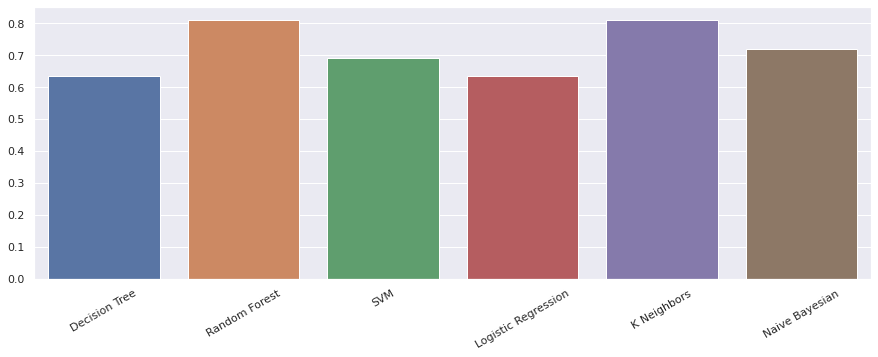

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(15,5))
figsize=(15,5)
ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

plt.xticks(rotation=30)
sns.barplot(acc_results[0], [np.mean(e) for e in acc_results[1]])